------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.9.9


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import math

c:\Users\lucyn\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lucyn\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\lucyn\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\lucyn\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
def parse_lexicon(file_path):
    lexicon = {}
    with open(file_path, 'r') as f:
        for line in f:
            attributes = line.strip().split()
            word = None
            polarity = None

            for attr in attributes:
                key, value = attr.split('=')
                if key == "word1":
                    word = value
                elif key == "priorpolarity":
                    polarity = value

            if polarity == "positive":
                lexicon[word] = 1
            elif polarity == "negative":
                lexicon[word] = -1
            elif polarity == "neutral":
                lexicon[word] = 0

    return lexicon

def compute_review_scores(json_file_path, lexicon):
    with open(json_file_path, 'r') as f:
        reviews = json.load(f)

    review_scores = []
    real_scores = []

    for review in reviews:
        score = 0
        for sentence in review["content"]:
            for word, tag in sentence:
                word = word.lower()
                if word in lexicon:
                    score += lexicon[word]

        if score > 8:
            binary_score = 1
        else:
            binary_score = -1

        review_scores.append(binary_score)
        real_scores.append(1 if review["sentiment"] == "POS" else -1)

    return review_scores, real_scores

# Example usage:
lexicon = parse_lexicon("sent_lexicon")
review_scores, real_scores = compute_review_scores("reviews.json", lexicon)


In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.

token_results = []
for i in range(len(review_scores)):
    if review_scores[i] == real_scores[i]:
        token_results.append(1)
    else:
        token_results.append(0)
# print(token_results)

token_accuracy = np.sum(token_results)/len(review_scores)

print("Accuracy:", token_accuracy)

Accuracy: 0.6775


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
def parse_lexicon(file_path):
    lexicon = {}
    with open(file_path, 'r') as f:
        for line in f:
            attributes = line.strip().split()
            word = None
            polarity = None
            magnitude = None

            for attr in attributes:
                key, value = attr.split('=')
                if key == "word1":
                    word = value
                elif key == "priorpolarity":
                    polarity = value
                elif key == "type":
                    magnitude = value

            if polarity == "positive" and magnitude == "strongsubj":
                lexicon[word] = 3 #chosen arbitrarily
            elif polarity == "positive" and magnitude == "weaksubj":
                lexicon[word] = 1
            elif polarity == "neutral":
                lexicon[word] = 0
            elif polarity == "negative" and magnitude == "strongsubj":
                lexicon[word] = -3 #chosen arbitrarily
            elif polarity == "negative" and magnitude == "weaksubj":
                lexicon[word] = -1

    return lexicon

def compute_review_scores(json_file_path, lexicon):
    with open(json_file_path, 'r') as f:
        reviews = json.load(f)

    review_scores = []
    real_scores = []
    mean_score = 0
    for review in reviews:
        score = 0
        for sentence in review["content"]:
            for word, _ in sentence:
                word = word.lower()
                if word in lexicon:
                    score += lexicon[word]

        if score > 8:
            binary_score = 1
        elif score <= 8:
            binary_score = -1
        mean_score += score

        review_scores.append(binary_score)
        real_scores.append(1 if review["sentiment"] == "POS" else -1)

    # print((mean_score)/len(reviews))

    return review_scores, real_scores


lexicon = parse_lexicon("sent_lexicon")
review_scores, real_scores = compute_review_scores("reviews.json", lexicon)

In [ ]:
magnitude_results = []
for i in range(len(review_scores)):
    if review_scores[i] == real_scores[i]:
        magnitude_results.append(1)
    else:
        magnitude_results.append(0)
# print(magnitude_results)

magnitude_accuracy = np.sum(magnitude_results)/len(magnitude_results)
print("Accuracy:" , magnitude_accuracy)

Accuracy: 0.6925


#### (Q.1.3) Make a barplot of the two results (0.5pt)

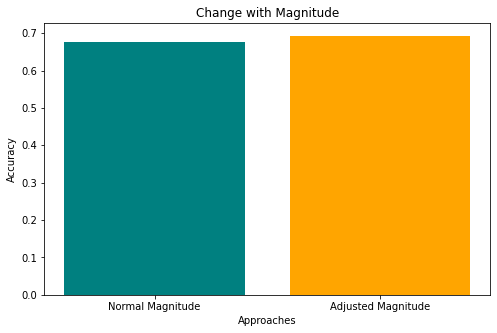

In [ ]:
labels = ['Normal Magnitude', 'Adjusted Magnitude']
values = [token_accuracy, magnitude_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color = ['teal', 'orange'])
plt.xlabel('Approaches')
plt.ylabel('Accuracy')
plt.title('Change with Magnitude')
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

> This might be a problem as just because a review is longer doesn't necessarily mean the sentiment is stronger. For example a longer neutral review could naturally have more both positive and negative words while a short negative review would have less, even when their sentiments are otherwise clear. Thus, we should normalize by the length of the review. As below, we implemented a word count per review counter by which to normalize. Here it was important to set the threshold correctly so we calculated it by taking the avarage score as the dataset. Overall this approach should ensure that the length of the review and thus incrased pos/neg word counts don't disproportionaltely influence the sentiment classification.


In [ ]:
# YOUR CODE HERE

def parse_lexicon(file_path):
    lexicon = {}
    with open(file_path, 'r') as f:

        for line in f:

            attributes = line.strip().split()
            word = None
            polarity = None
            magnitude = None

            for attr in attributes:
                key, value = attr.split('=')
                if key == "word1":
                    word = value
                elif key == "priorpolarity":
                    polarity = value
                elif key == "type":
                    magnitude = value

            if polarity == "positive" and magnitude == "strongsubj":
                lexicon[word] = 3 #chosen arbitrarily
            elif polarity == "positive" and magnitude == "weaksubj":
                lexicon[word] = 1
            elif polarity == "neutral":
                lexicon[word] = 0
            elif polarity == "negative" and magnitude == "strongsubj":
                lexicon[word] = -3 #chosen arbitrarily
            elif polarity == "negative" and magnitude == "weaksubj":
                lexicon[word] = -1

    return lexicon

def compute_review_scores(json_file_path, lexicon):
    with open(json_file_path, 'r') as f:
        reviews = json.load(f)

    review_scores = []
    real_scores = []
    mean_score = 0
    for review in reviews:
        score = 0
        sentence_count  = 0
        word_count = 0
        for sentence in review["content"]:
            sentence_count += 1
            for word, _ in sentence:
                word = word.lower()
                word_count += 1
                if word in lexicon:
                    score += lexicon[word]

        if word_count > 0:
            norm_score = score / word_count

        else: # if somehow there are no words in the review prevent division by zero
            norm_score = score

        if norm_score > 0.018:
            binary_score = 1
        else:
            binary_score = -1
        mean_score += norm_score
        review_scores.append(binary_score)
        real_scores.append(1 if review["sentiment"] == "POS" else -1)

    print(mean_score/len(reviews)) # this is how i get my threshold

    return review_scores, real_scores

lexicon = parse_lexicon("sent_lexicon")

review_scores, real_scores = compute_review_scores("reviews.json", lexicon)

accuracy = 0
for i in range(len(review_scores)):
    if review_scores[i] == real_scores[i]:
        accuracy += 1
accuracy = accuracy / len(review_scores)


# print(review_scores)
# print(real_scores)
# print(accuracy)

0.01841402592400109


In [ ]:
count_results = []
for i in range(len(review_scores)):
    if review_scores[i] == real_scores[i]:
        count_results.append(1)
    else:
        count_results.append(0)
# print(count_results)

count_accuracy = np.sum(count_results)/len(count_results)
print("Accuracy:" , count_accuracy)

Accuracy: 0.695


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?


When we skip words for only one class during test-time calculations, the classifier becomes biased. For example, if a word like "xyz" appears in the training set for class C1 but is absent from class C2, excluding this word for class C2 during testing effectively penalizes class C1. In Naive Bayes, probabilities are calculated by multiplying fractions, so removing a word from one class results in performing one less multiplication, leading to a larger overall probability for that class. This creates a bias in favor of class C2, regardless of how frequently "xyz" appears in C1. This approach is counterintuitive because observed words should increase the likelihood of a review belonging to their respective class, not reduce it.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
# Split data into train and test sets
train_reviews = [r for r in reviews if 0 <= r["cv"] <= 899]
test_reviews = [r for r in reviews if 900 <= r["cv"] <= 999]

# Vocabulary and word counts by class
vocab = Counter()
class_word_counts = {"POS": Counter(), "NEG": Counter()}
class_counts = {"POS": 0, "NEG": 0}

# Build vocabulary and class word counts from training data
for review in train_reviews:
    sentiment = review["sentiment"]
    class_counts[sentiment] += 1
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            word = token.lower()
            vocab[word] += 1
            class_word_counts[sentiment][word] += 1

def calculate_piors(train_reviews, class_counts):
  # Calculate prior probabilities
  total_train_reviews = len(train_reviews)
  priors = {
      "POS": class_counts["POS"] / total_train_reviews,
      "NEG": class_counts["NEG"] / total_train_reviews
  }

  return priors

# Function to calculate log-probabilities (skipping unseen words)
def calculate_log_prob(review, sentiment, priors):
    log_prob = math.log(priors[sentiment])
    total_words_in_class = sum(class_word_counts[sentiment].values())

    for sentence in review["content"]:
        for token, pos_tag in sentence:
            word = token.lower()
            # Ignore words unseen in the training set for either class
            if word in class_word_counts["POS"] and word in class_word_counts["NEG"]:
                word_count = class_word_counts[sentiment].get(word, 0)
                log_prob += math.log(word_count / total_words_in_class)

    return log_prob

# Predict on test set and calculate accuracy
correct_predictions = 0

# Calculate prior probabilities
priors = calculate_piors(train_reviews, class_counts)

for review in test_reviews:
    pos_log_prob = calculate_log_prob(review, "POS", priors)
    neg_log_prob = calculate_log_prob(review, "NEG", priors)

    predicted_sentiment = "POS" if pos_log_prob > neg_log_prob else "NEG"

    if predicted_sentiment == review["sentiment"]:
        correct_predictions += 1

accuracy = correct_predictions / len(test_reviews)
print("Classification accuracy:", accuracy)


Classification accuracy: 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

Using accuracy as an evaluation metric in scenarios with significant class imbalance is generally not advisable. In such cases, the classifier could easily achieve high accuracy by simply predicting the majority class for all instances. For example, if the test set is 90% positive, a classifier that always predicts the positive class would achieve 90% accuracy without actually learning anything meaningful about the data.

However, this exact scenario may not apply to the Naive Bayes classifier The classifier will most likely be biased towards one of the classes, but not neccessarily towards the majority class. On one hand, the prior becomes much stronger for the majority class. On the other hand, the lower total word counts in the denominator will lead to higher likelihoods of the words in the minority class.

In our case, we can see that the accuracy drops from 82.5% to 60% when using the imbalanced dataset. We can also notice that the classifier is biased towards the minority class by examining precision, recall and f1 scores.


In [ ]:
# Split data into train and test sets
train_reviews_biased = [r for r in reviews if ((0 <= r["cv"] <= 89) or ((90 <= r["cv"] <= 899) and r['sentiment'] == 'POS'))]
test_reviews_biased = [r for r in reviews if ((900 <= r["cv"] <= 909) or ((900 <= r["cv"] <= 999) and r['sentiment'] == 'POS'))]

# Vocabulary and word counts by class
vocab_biased = Counter()
class_word_counts_biased = {"POS": Counter(), "NEG": Counter()}
class_counts_biased = {"POS": 0, "NEG": 0}

# Build vocabulary and class word counts from training data
for review in train_reviews_biased:
    sentiment = review["sentiment"]
    class_counts_biased[sentiment] += 1
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            word = token.lower()
            vocab_biased[word] += 1
            class_word_counts_biased[sentiment][word] += 1

# Calculate prior probabilities
total_train_reviews_biased = len(train_reviews_biased)
priors_biased = {
    "POS": class_counts_biased["POS"] / total_train_reviews_biased,
    "NEG": class_counts_biased["NEG"] / total_train_reviews_biased
}

# Function to calculate log-probabilities (skipping unseen words)
def calculate_log_prob(review, sentiment):
    log_prob = math.log(priors_biased[sentiment])
    total_words_in_class = sum(class_word_counts_biased[sentiment].values())

    for sentence in review["content"]:
        for token, pos_tag in sentence:
            word = token.lower()
            # Ignore words unseen in the training set for either class
            if word in class_word_counts_biased["POS"] and word in class_word_counts_biased["NEG"]:
                word_count = class_word_counts_biased[sentiment].get(word, 0)
                log_prob += math.log(word_count / total_words_in_class)

    return log_prob

# Predict on test set and calculate accuracy, precision, recall, and F1 score
correct_predictions = 0
tp = {"POS": 0, "NEG": 0}  # True positives for each class
fp = {"POS": 0, "NEG": 0}  # False positives for each class
fn = {"POS": 0, "NEG": 0}  # False negatives for each class

for review in test_reviews_biased:
    pos_log_prob = calculate_log_prob(review, "POS")
    neg_log_prob = calculate_log_prob(review, "NEG")

    predicted_sentiment = "POS" if pos_log_prob > neg_log_prob else "NEG"
    actual_sentiment = review["sentiment"]

    if predicted_sentiment == actual_sentiment:
        correct_predictions += 1
        tp[actual_sentiment] += 1
    else:
        fp[predicted_sentiment] += 1
        fn[actual_sentiment] += 1

accuracy = correct_predictions / len(test_reviews_biased)
print("Classification accuracy:", accuracy)

# Calculate precision, recall, and F1 score for each class
for sentiment in ["POS", "NEG"]:
    precision = tp[sentiment] / (tp[sentiment] + fp[sentiment]) if (tp[sentiment] + fp[sentiment]) > 0 else 0
    recall = tp[sentiment] / (tp[sentiment] + fn[sentiment]) if (tp[sentiment] + fn[sentiment]) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{sentiment} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

# Calculate the macro-averaged F1 score
macro_f1_score = sum((2 * (tp[s] / (tp[s] + fp[s])) * (tp[s] / (tp[s] + fn[s]))) / ((tp[s] / (tp[s] + fp[s])) + (tp[s] / (tp[s] + fn[s]))) if ((tp[s] / (tp[s] + fp[s])) + (tp[s] / (tp[s] + fn[s]))) > 0 else 0 for s in ["POS", "NEG"]) / 2
print(f"Macro-averaged F1 Score: {macro_f1_score:.4f}")


Classification accuracy: 0.6
POS - Precision: 0.9828, Recall: 0.5700, F1 Score: 0.7215
NEG - Precision: 0.1731, Recall: 0.9000, F1 Score: 0.2903
Macro-averaged F1 Score: 0.5059


In [ ]:
print(tp)
print(fp)

{'POS': 57, 'NEG': 9}
{'POS': 1, 'NEG': 43}


In [ ]:
print(priors_biased)

{'POS': 0.9090909090909091, 'NEG': 0.09090909090909091}


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [ ]:
# Function to calculate log-probabilities (Laplace smoothing)
def calculate_log_prob_Laplace(review, sentiment, priors, class_word_counts, vocab, stemmer = None):
    log_prob = math.log(priors[sentiment])
    total_words_in_class = sum(class_word_counts[sentiment].values())

    for sentence in review["content"]:
        for token, pos_tag in sentence:
            word = token.lower()
            if stemmer is not None:
                word = stemmer.stem(word)
            # Laplace smoothing k = 1
            word_count = class_word_counts[sentiment].get(word, 0) + 1
            log_prob += math.log(word_count / (total_words_in_class + len(vocab)))

    return log_prob

def test_Laplace(test_reviews, priors, class_word_counts, vocab, stemmer = None):
  # Predict on test set and calculate accuracy
  correct_predictions = 0

  for review in test_reviews:
      pos_log_prob = calculate_log_prob_Laplace(review, "POS", priors, class_word_counts, vocab, stemmer)
      neg_log_prob = calculate_log_prob_Laplace(review, "NEG", priors, class_word_counts, vocab, stemmer)

      predicted_sentiment = "POS" if pos_log_prob > neg_log_prob else "NEG"

      if predicted_sentiment == review["sentiment"]:
          correct_predictions += 1

  accuracy = correct_predictions / len(test_reviews)

  return accuracy

# Report the accuracy
print("Classification accuracy:", test_Laplace(test_reviews, priors, class_word_counts, vocab))

# Report the accuracy on biased dataset
print("Classification accuracy on the biased dataset:", test_Laplace(test_reviews_biased, priors_biased, class_word_counts_biased, vocab_biased))


Classification accuracy: 0.825
Classification accuracy on the biased dataset: 0.9181818181818182


Using Laplace smoothing on the balanced dataset did not affect classification accuracy, as both classes already had sufficient representation of words, making smoothing redundant.
However, on the unbalanced dataset, Laplace smoothing led to a significant accuracy improvement, increasing from 60% to 91.82%. This improvement highlights the effectiveness of Laplace smoothing in handling unbalanced datasets. Unlike the approach of discarding unseen words, Laplace smoothing assigns a small, non-zero probability to all words, ensuring that rare or unseen words in the minority class still contribute to the classification.
This correction eliminates the bias observed in Q2.3, where the model favored the minority class due to its lower total word count in the denominator. With Laplace smoothing, while the total word count is still lower for the minority class, it is counterbalanced by assigning low probabilities to unseen words, resulting in more balanced predictions and a significant boost in model performance.

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
def build_vocab(train_reviews, stemmer = None):

  # Vocabulary and word counts by class for training data
  vocab = Counter()
  class_word_counts = {"POS": Counter(), "NEG": Counter()}
  class_counts = {"POS": 0, "NEG": 0}

  # Build vocabulary and class word counts from training data
  for review in train_reviews:
      sentiment = review["sentiment"]
      class_counts[sentiment] += 1
      for sentence in review["content"]:
          for token, pos_tag in sentence:
              word = token.lower()
              if stemmer is not None:
                word = stemmer.stem(word)
              vocab[word] += 1
              class_word_counts[sentiment][word] += 1
  return vocab, class_word_counts, class_counts

In [ ]:
# The function for 10-fold cross-validation with round-robin splitting
def round_robin_cv(reviews, stemmer = None):
    accuracies = []

    # Loop over each fold from 0 to 9
    for fold in range(10):
        # Split the dataset into training and testing based on round-robin rule
        train_reviews = [r for r in reviews if r["cv"] % 10 != fold]
        test_reviews = [r for r in reviews if r["cv"] % 10 == fold]

        vocab, class_word_counts, class_counts = build_vocab(train_reviews, stemmer)

        # Calculate prior probabilities
        priors = calculate_piors(train_reviews, class_counts)

        # Calculate accuracy
        accuracy = test_Laplace(test_reviews, priors, class_word_counts, vocab, stemmer)
        accuracies.append(accuracy)
        print(f"Fold {fold} accuracy: {accuracy:.4f}")

    # Calculate and report final accuracy
    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average accuracy across 10 folds: {average_accuracy:.4f}")
    return average_accuracy, accuracies

# Perform CV for the reviews dataset
average_accuracy, accuracies = round_robin_cv(reviews)


Fold 0 accuracy: 0.7900
Fold 1 accuracy: 0.8350
Fold 2 accuracy: 0.8100
Fold 3 accuracy: 0.8300
Fold 4 accuracy: 0.7750
Fold 5 accuracy: 0.8500
Fold 6 accuracy: 0.8300
Fold 7 accuracy: 0.7800
Fold 8 accuracy: 0.8250
Fold 9 accuracy: 0.8450
Average accuracy across 10 folds: 0.8170



The average accuracy observed with cross-validation (81.70%) is comparable to the accuracy achieved without cross-validation in Q.2.4. However, it is slightly lower than the 82.5% accuracy reported in the non-cross-validated case.

#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [ ]:
# Calculate variance using previously found average accuracy and list of all accuracies
variance = sum((accuracy - average_accuracy) ** 2 for accuracy in accuracies) / len(accuracies)

print("Variance of the 10 accuracy scores:", variance)


Variance of the 10 accuracy scores: 0.0006509999999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
print('Already included the possibility of using the stemmer in previously defined helper functions.')

Already included the possibility of using the stemmer in previously defined helper functions.


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [ ]:
# Perform CV for the reviews dataset using Porter stemmer
average_accuracy, accuracies = round_robin_cv(reviews, stemmer = PorterStemmer())

Fold 0 accuracy: 0.7800
Fold 1 accuracy: 0.8400
Fold 2 accuracy: 0.8100
Fold 3 accuracy: 0.8500
Fold 4 accuracy: 0.7750
Fold 5 accuracy: 0.8350
Fold 6 accuracy: 0.8100
Fold 7 accuracy: 0.7750
Fold 8 accuracy: 0.8300
Fold 9 accuracy: 0.8400
Average accuracy across 10 folds: 0.8145


The use of stemming results in a slight decrease in average accuracy, dropping from 81.70% in the base case to 81.45% when stemming is applied.

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

Not sure what was meant by 'held-out training set'. Performing all calculations on 'train_reviews' created in Q2.2 and reused in Q2.4

In [ ]:
print(f'Amount of training samples: {len(train_reviews)}')

vocab_no_stemmer,_,_ = build_vocab(train_reviews, stemmer = None)
print(f'Size of the vocabulary when not using stemming: {len(vocab_no_stemmer)}')

vocab_porter,_,_ = build_vocab(train_reviews, stemmer = PorterStemmer())
print(f'Size of the vocabulary when using Porter stemming: {len(vocab_porter)}')

Amount of training samples: 1800
Size of the vocabulary when not using stemming: 45348
Size of the vocabulary when using Porter stemming: 32404


The vocabulary size decreases significantly when stemming is applied, which is an expected outcome. Stemming works by reducing related words to a common root form, thereby consolidating multiple word forms into a single stem. For instance, words like 'relaxed' and 'relaxing' are both reduced to the stem 'relax', effectively shrinking the vocabulary size by eliminating variations of the same word.

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# Define function to create n-grams from sentences
def create_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

def build_vocab_ngram(train_reviews, stemmer = None, ngram_values = [1]):

  # Vocabulary and word counts by class for training data
  vocab = Counter()
  class_word_counts = {"POS": Counter(), "NEG": Counter()}
  class_counts = {"POS": 0, "NEG": 0}

  # Build vocabulary and class word counts from training data
  for review in train_reviews:
      sentiment = review["sentiment"]
      class_counts[sentiment] += 1
      for sentence in review["content"]:
          # Tokenize the sentence
          tokens = [token.lower() for token, pos_tag in sentence]
          if stemmer is not None:
              tokens = [stemmer.stem(token) for token in tokens]
          # Create n-grams based on the specified values
          for n in ngram_values:
              n_grams = create_ngrams(tokens, n)
              for n_gram in n_grams:
                  vocab[n_gram] += 1
                  class_word_counts[sentiment][n_gram] += 1

  return vocab, class_word_counts, class_counts

In [ ]:
# Define function for 10-fold cross-validation with round-robin splitting
def round_robin_cv_ngram(reviews, stemmer=None, ngram_values=[1]):
    accuracies = []

    for fold in range(10):
        train_reviews = [r for r in reviews if r["cv"] % 10 != fold]
        test_reviews = [r for r in reviews if r["cv"] % 10 == fold]

        # Use the new function to build the vocabulary and class counts
        vocab, class_word_counts, class_counts = build_vocab_ngram(train_reviews, stemmer, ngram_values)

        # Calculate prior probabilities
        total_train_reviews = len(train_reviews)
        priors = {
            "POS": class_counts["POS"] / total_train_reviews,
            "NEG": class_counts["NEG"] / total_train_reviews
        }

        # Function to calculate log-probabilities with Laplace smoothing
        def calculate_log_prob(review, sentiment):
            log_prob = math.log(priors[sentiment])
            total_words_in_class = sum(class_word_counts[sentiment].values())

            for sentence in review["content"]:
                tokens = [token.lower() for token, pos_tag in sentence]
                for n in ngram_values:
                    n_grams = create_ngrams(tokens, n)
                    for n_gram in n_grams:
                        word_count = class_word_counts[sentiment].get(n_gram, 0) + 1
                        log_prob += math.log(word_count / (total_words_in_class + len(vocab)))

            return log_prob

        # Predict on test set and calculate accuracy
        correct_predictions = 0

        for review in test_reviews:
            pos_log_prob = calculate_log_prob(review, "POS")
            neg_log_prob = calculate_log_prob(review, "NEG")

            predicted_sentiment = "POS" if pos_log_prob > neg_log_prob else "NEG"
            if predicted_sentiment == review["sentiment"]:
                correct_predictions += 1

        accuracy = correct_predictions / len(test_reviews)
        accuracies.append(accuracy)
        print(f"Fold {fold} accuracy: {accuracy:.4f}")

    final_performance = sum(accuracies) / len(accuracies)
    print(f"Average accuracy across 10 folds: {final_performance:.4f}")

# Perform CV for the reviews dataset using 1,2-grams
print('Using unigrams and bigrams')
round_robin_cv_ngram(reviews, ngram_values=[1,2])

# Perform CV for the reviews dataset using 1,2,3-grams
print('\n')
print('-'*30)
print('\n')
print('Using unigrams, bigrams and trigrams')
round_robin_cv_ngram(reviews, ngram_values=[1,2,3])


Using unigrams and bigrams
Fold 0 accuracy: 0.8000
Fold 1 accuracy: 0.8650
Fold 2 accuracy: 0.8350
Fold 3 accuracy: 0.8700
Fold 4 accuracy: 0.8150
Fold 5 accuracy: 0.8750
Fold 6 accuracy: 0.8250
Fold 7 accuracy: 0.8400
Fold 8 accuracy: 0.8650
Fold 9 accuracy: 0.8450
Average accuracy across 10 folds: 0.8435


------------------------------


Using unigrams, bigrams and trigrams
Fold 0 accuracy: 0.8000
Fold 1 accuracy: 0.8700
Fold 2 accuracy: 0.8500
Fold 3 accuracy: 0.8800
Fold 4 accuracy: 0.8100
Fold 5 accuracy: 0.9000
Fold 6 accuracy: 0.8250
Fold 7 accuracy: 0.8400
Fold 8 accuracy: 0.8700
Fold 9 accuracy: 0.8350
Average accuracy across 10 folds: 0.8480



Incorporating both unigrams and bigrams leads to a noticeable improvement in performance, with the average accuracy increasing to 84.35%. This outperforms the cases where only unigrams (81.70%) or stemmed unigrams (81.45%) were used. Adding trigrams provides a slight additional boost, bringing the average accuracy to 84.40%. This demonstrates that using a combination of n-grams can capture more contextual information, leading to better overall accuracy.


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)?
Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set once again for this.


Same as in Q2.8. Not sure what was meant by 'held-out training set'.

Performing all calculations on 'train_reviews' created in Q2.2 and reused in Q2.4

The number of features could theoretically grow exponentially as we include higher-order n-grams. However, in practice, most potential n-grams do not appear in the observed sentences, so the actual growth is much slower than the theoretical maximum.
Based on calculations performed on the 10th cross-validation (CV) training set:
- The size of the unigram vocabulary is 45,348.
- The size of the unigram + bigram vocabulary is 465,262, which is approximately 10 times the size of the unigram vocabulary.
- The size of the unigram + bigram + trigram vocabulary is 1,346,107, which is approximately:
 - 30 times the size of the unigram vocabulary.
 - 3 times the size of the unigram + bigram vocabulary.

These figures show that while the feature set grows significantly when moving from unigrams to bigrams, the rate of growth diminishes when adding trigrams. This trend suggests that as we incorporate larger n-grams, the rate of increase in vocabulary size will continue to slow.

In [ ]:
print(f'Amount of training samples: {len(train_reviews)}')
stemmer = PorterStemmer()

vocab_no_stemmer,_,_ = build_vocab(train_reviews, stemmer = None)
print(f'Size of the unigram vocabulary when not using stemming: {len(vocab_no_stemmer)}')

vocab_porter,_,_ = build_vocab(train_reviews, stemmer)
print(f'Size of the unigram vocabulary when using Porter stemming: {len(vocab_porter)}')

two_gram_vocab_no_stemmer,_,_ = build_vocab_ngram(train_reviews, stemmer = None, ngram_values = [1,2])
print(f'Size of the 1,2-gram vocabulary when not using stemming: {len(two_gram_vocab_no_stemmer)}')

two_gram_vocab_porter,_,_ = build_vocab_ngram(train_reviews, stemmer, ngram_values = [1,2])
print(f'Size of the 1,2-gram vocabulary when using Porter stemming: {len(two_gram_vocab_porter)}')

three_gram_vocab_no_stemmer,_,_ = build_vocab_ngram(train_reviews, stemmer = None, ngram_values = [1,2,3])
print(f'Size of the 1,2,3-gram vocabulary when not using stemming: {len(three_gram_vocab_no_stemmer)}')

three_gram_vocab_porter,_,_ = build_vocab_ngram(train_reviews, stemmer, ngram_values = [1,2,3])
print(f'Size of the 1,2,3-gram vocabulary when using Porter stemming: {len(three_gram_vocab_porter)}')

Amount of training samples: 1800
Size of the unigram vocabulary when not using stemming: 45348
Size of the unigram vocabulary when using Porter stemming: 32404
Size of the 1,2-gram vocabulary when not using stemming: 465262
Size of the 1,2-gram vocabulary when using Porter stemming: 407943
Size of the 1,2,3-gram vocabulary when not using stemming: 1346107
Size of the 1,2,3-gram vocabulary when using Porter stemming: 1265912


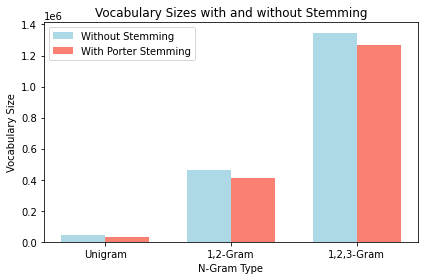

In [ ]:
# Collecting the vocabulary sizes
sizes = {
    'Unigram': [len(vocab_no_stemmer), len(vocab_porter)],
    '1,2-Gram': [len(two_gram_vocab_no_stemmer), len(two_gram_vocab_porter)],
    '1,2,3-Gram': [len(three_gram_vocab_no_stemmer), len(three_gram_vocab_porter)],
}

# Setting the x-axis labels and bar width
labels = list(sizes.keys())
bar_width = 0.35

# Create the figure and axis
fig, ax = plt.subplots()

# Setting positions for the bars
x = range(len(labels))

# Plotting the bars for each set of vocabulary sizes
bars1 = ax.bar([i - bar_width/2 for i in x], [sizes[label][0] for label in labels],
                width=bar_width, label='Without Stemming', color='lightblue')
bars2 = ax.bar([i + bar_width/2 for i in x], [sizes[label][1] for label in labels],
                width=bar_width, label='With Porter Stemming', color='salmon')

# Adding labels and title
ax.set_xlabel('N-Gram Type')
ax.set_ylabel('Vocabulary Size')
ax.set_title('Vocabulary Sizes with and without Stemming')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X = [" ".join([token for sentence in review["content"] for token, pos_tag in sentence]) for review in reviews]
y = [1 if review["sentiment"] == "POS" else 0 for review in reviews]

vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

svm_clf = LinearSVC(max_iter=10000)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("Performance:")
print(classification_report(y_test, y_pred_svm))

Performance:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       199
           1       0.83      0.82      0.82       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [ ]:
svm_cv_scores = cross_val_score(svm_clf, X_vec, y, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {svm_cv_scores.mean():.4f} +/- {svm_cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.8425 +/- 0.0211


> Looking at the Naive Bayes implementaiton in Section 2, we can see the Naive Bayes with smoothing achieved an accuracy of 82.5%, while the SVM achieves accuracy of between 81-86%. Looking at cross-validation provides the differnce in their accuracy rates within trianing , as the Naive Bayes cross-validation score (taking the avarage accuracy over 10 folds) was up to 95.95% while the SVM cross-validation across ten folds was only 84.25%.

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
X_pos = [" ".join([f"{token}_{pos_tag}" for sentence in review["content"] for token, pos_tag in sentence]) for review in reviews]
y = [1 if review["sentiment"] == "POS" else 0 for review in reviews]


# print(X_pos[0:5])

vectorizer = CountVectorizer()
X_vec_pos = vectorizer.fit_transform(X_pos)


X_train, X_test, y_train, y_test = train_test_split(X_vec_pos, y, test_size=0.2, random_state=42)

svm_clf_pos = LinearSVC(max_iter=100000)
svm_clf_pos.fit(X_train, y_train)

y_pred_svm_pos = svm_clf_pos.predict(X_test)

print("SVM Classifier Performance (Word+POS tag) Test Set:")
print(classification_report(y_test, y_pred_svm_pos))

svm_cv_scores_pos = cross_val_score(svm_clf_pos, X_vec_pos, y, cv=10, scoring='accuracy')
print(f"SVM Classifier Cross-Validation Accuracy (Word+POS tags): {svm_cv_scores_pos.mean():.4f} +/- {svm_cv_scores_pos.std():.4f}")


SVM Classifier Performance (Word+POS tag) Test Set:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       199
           1       0.83      0.82      0.82       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

SVM Classifier Cross-Validation Accuracy (Word+POS tags): 0.8460 +/- 0.0166


> There is a slight improvement looking a the Cross-Validation accuracy, which with POS features is 84.60% while without POS it was 84.25%. While small, there is an improvement using POS tagging information. This is likely because it potentiall helps add context so that the SVM can better understand the significance of the sentence structure and syntactic roles, such as highlighting the importance of adjectives in determining the sentiment. From a theoretical perspective including this information then makes sense given its inherent additinal gramatical information which can highlight nuances in language previously unseen, and perhaps a more in depth implementation of the token-POS tag relation might yield even better results.


#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
open_class_tags = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
X_open_class = [" ".join([f"{token}" for sentence in review["content"]
                         for token, pos_tag in sentence if pos_tag in open_class_tags]) for review in reviews]

vectorizer = CountVectorizer()
X_vec_open_class = vectorizer.fit_transform(X_open_class)

X_train, X_test, y_train, y_test = train_test_split(X_vec_open_class, y, test_size=0.2, random_state=42)

svm_clf_open_class = LinearSVC(max_iter=10000)
svm_clf_open_class.fit(X_train, y_train)

y_pred_svm_open_class = svm_clf_open_class.predict(X_test)
print("SVM Classifier Performance (Open-Class Features Only) Test Set:")
print(classification_report(y_test, y_pred_svm_open_class))

svm_cv_scores_open_class = cross_val_score(svm_clf_open_class, X_vec_open_class, y, cv=10, scoring='accuracy')
print(f"SVM Classifier Cross-Validation Accuracy (Open-Class Features Only): {svm_cv_scores_open_class.mean():.4f} +/- {svm_cv_scores_open_class.std():.4f}")

SVM Classifier Performance (Open-Class Features Only) Test Set:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       199
           1       0.83      0.81      0.82       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

SVM Classifier Cross-Validation Accuracy (Open-Class Features Only): 0.8445 +/- 0.0223


> Getting rid of all closed-form words improved the performace. We are using a model similar to 3.1. Accuracy is also 82% while using the same seed as for the SVM with all words inluded. The cross-validation accuracy for this SVM is 84.45%, again an improvement as compared to SVM in 3.1 which was 84.25%. While only slight, it is much more efficient than the implementation in 3.2 considering the vocabulary size. While I wouldn't go as far as to say these words are detrimental, as even with them we get a reasonable accuracy, it makes the model more efficient to train without them which makes it a worthwhile endavor for future applications on larger datasets. In theory I cannot think of a reason to keep them especially without using context or surrounding words such as here, which should result in a more robust classifier.


# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [ ]:
# Write your names and student numbers here:
# Piotr Sobecki # 15127206
# Lucia Sikulova # 13549634

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.